                                                                                                MSC 10-2022

# Filtering

- [**Imports**](#Imports)
- [**Introduction**](#Introduction)
- [**Finite Impulse Response Filters (FIR)**](#Finite-Impulse-Response-Filters-(FIR))
    - [**Mathematics**](#Mathematics)
    - [**FIR Filter Design in Openseize**](#FIR-Filter-Design-in-Openseize)
    - [**General Cosine Window Design**](#General-Cosine-Window-Design)
    - [**Parameterized Window Design**](#Parameterized-Window-Design)
    - [**Parks-McClellan Window Design**](#Parks-McClellan-Window-Design)
    - [**Applying FIR Filters to Large Datasets**](#Applying-FIR-Filters-to-Large-Datasets)
    - [**Practical Considerations & Recommendations**](#Practical-Considerations-&-Recommendations)
- [**Infinite Impulse Response Filters (IIR)**](#Infinite-Impulse-Response-Filters-(FIR))
    - [**Mathematics**](#Mathematics)
    - [**IIR Filter Design in Openseize**](#IIR-Filter-Design-in-Openseize)
    - [**Transfer Function Coeffecient Formats**](#Transfer-Function-Coeffecient-Formats)
    - [**Practical Considerations & Recommendations**](#Practical-Considerations-&-Recommendations)
- [**Notch Filters**](#Notch-Filters) 

## Imports

In [1]:
import sys
import inspect
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from openseize.filtering import fir, iir
from openseize import demos
from openseize.io.edf import Reader
from openseize import producer

## Introduction

This tutorial covers the mathematics, design and application of filters in Openseize. Since this is a deep subject, the tutorial can be approached in two ways. First, readers that are interested in understanding the principles that govern filter design methods, the sections headed by "Mathematics" are a starting point and include references for deeper study. Second, readers who are only interested in the practical implementation of each filter can safely skip these sections but be sure to carefully read the "Practical Considerations and Recommendations" sections.
<br>
<br>
Lastly it is important to remember that there are two stages to filtering data. The first is to design a filter that meets a specific set of design criteria and second to apply the filter to a potentially very large data set. Openseize streamlines these two processes by allowing clients to create filter objects with methods that handle both the filter design and the iterative application of the filter to data that may not fit into RAM. The application of the filter to large data is carried out using the overlap-add method for FIR filters and initial conditioning for IIR filters. This tutorial does not specifically address those algorithms. For details on this iterative implementation of filters, please see the openseize.numerical module. It has detailed documentation on the nitty-gritty of applying filters to large datasets.  

<h1 style="text-align: center;"> Finite Impulse Response Filters (FIR) </h1>

## Mathematics

A Finite Impulse Response filter is a set of coeffecients $h[n]$ used to weight previous signal samples $x[n]$ to yield each filtered output $y[n]$.
<br>
<br>
<p style="text-align: center;">
    $
    y[n] = \sum \limits_{i=0}^{N} h[i] \ x[n-i] \quad (1)
    $ 
</p>

This operation, called convolution, requires N multiplications and N additions for each output value $y[n]$.
<b> Our goal is to find a set of N coeffecients for $h$ such that the frequency response of the filter meets a set of design criteria while keeping the filter order, N, low.</b>. 
<br>
<br>
Openseize defaults to using Type I FIR filters which means that that the filter order is an even number N=2M and the filter has an initial phase $\phi_0 = 0$. Since the sum in (1) runs from 0 to N there are N+1 total terms. This number (N+1) is called the number of taps. To find a good set of coeffecients for h, we start by defining what the ideal response of the filter should be in the frequency domain. To keep things general lets assume we are designing a bandpass filter from $\theta_1$ to $\theta_2$ where $\theta$ is in units of rads/sec.

The <b>ideal amplitude response</b> of our bandpass filter is then:
<br>
<br>
<p style="text-align: center;">
    $
    A_{d}(\theta) = \begin{cases}
                           1 & \theta_1 \leq |\theta| \leq \theta_2 \\
                            0 & otherwise
                       \end{cases} \quad (2)
    $
</p>
<br>
<br>
Lets now write a function that creates this ideal amplitude response and plot an example.

In [2]:
def ideal_amplitude_response(low, high, n=1000):
    """Creates the ideal amplitude response of a bandpass filter.
    
    Args:
        low: float
            The low frequency cutoff in rads/sec.
        high: float
            The high frequency cutoff in rads/sec.
        n: int
            The number of frequencies between 0 and Nyquist = pi radians to return amplitudes at. 
            Default is 1000 frequencies.
            
    Returns: An array of frequencies between 0 and 1 and an array of corresponding amplitudes.
    """
    
    thetas = np.linspace(0, 1, 1000)
    amplitudes = (thetas >= low / np.pi) & (thetas <= high / np.pi)
    return thetas, amplitudes

In [3]:
def plot_ideal_response(thetas, amplitudes, ax, **kwargs):
    """Plots the ideal amplitude response of a bandpass filter to an axis.
    
    Args:
        thetas: 1-D array
            Array of frequencies between 0 and 1.
        amplitudes: 1-D array
            Array of amplitudes, one for each theta in thetas.
        ax: mpl axis
            A matplotlib axis to display to.
    """
    
    ax.plot(thetas, amplitudes, **kwargs)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.set_xlabel(r'$\theta$', fontsize=14)
    ax.set_ylabel(r'$A_d(\theta)$', fontsize=14)

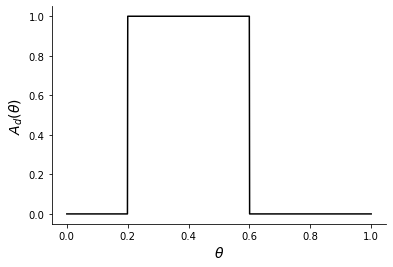

In [4]:
low = 0.2 * np.pi
high = 0.6 * np.pi
thetas, amplitudes = ideal_amplitude_response(low, high, n=1000)

fig, ax = plt.subplots()
plot_ideal_response(thetas, amplitudes, ax, color='k')
plt.show()

The ideal amplitude response (Eq. 2) is part of the <b>ideal frequency response</b> $H_d^f(\theta)$ of the FIR filter. The frequency response includes the amplitude response and the phase of the filter.
<br>
<br>
<p style="text-align: center;">
    $
    H_d^f(\theta) = A_d(\theta)\ e^{-i\theta N/2} \quad (3) 
    $ 
</p>

The phase delay tells us that the filtered output y[n] will be **delayed** relative to x[n]. For Type I FIR filters (openseize's default), this delay is a constant N/2.
<br>
<br>
<b>Remember our goal, we want to find $h[n]$</b>. Since we have the ideal frequency response (3) we can use the inverse Fourier transform to get the ideal/desired filter $h_d[n]$.
<br>
<br>
By substituting 2 into 3 and taking the inverse Fourier transform we get $h_d[n]$ also called the ideal impulse response:

<p style="text-align: center;">
    $ 
    \begin{align*}
    h_d[n] &= \frac{1}{2\pi} \int \limits_{-\theta_2}^{\theta_1}e^{i \theta (n-N/2)} d\theta + \frac{1}{2\pi} \int \limits_{\theta_1}^{\theta_2}e^{i \theta (n-N/2)}d\theta \quad (4)\\
    \\
    &= \frac{\sin(\theta_2(n-N/2))}{\pi(n-N/2)} - \frac{\sin(\theta_1(n-N/2))}{\pi(n-N/2)} \quad (5)\\
    \\
    &= \frac{\theta_2}{\pi}sinc[\frac{\theta_2(n-N/2)}{\pi}]- \frac{\theta_1}{\pi}sinc[\frac{\theta_1(n-N/2)}{\pi}] \quad (6)
    \end{align*}
    $
</p>

Notice that $h_d[n]$ is a <b>function</b> of n where n is an integer, it is <b>defined for all integers n!</b> So in order to create a filter we can actually apply, we must <font color='firebrick'><b><u>TRUNCATE</b></u></font> $h_d[n]$. 
<br>
<br>
<p style="text-align: center;">
    $
    \begin{align*}
    h[n] = \begin{cases}
               h_d[n] & 0 \leq n \leq N \\
               0 & otherwise
           \end{cases} \quad (7)
    \end{align*}
    $
</p>

Lets build a function that computes the truncated impulse response $h[n]$.

In [5]:
def impulse(low, high, N):
    """Returns a truncated impulse response function h[n] of a Type I FIR.
    
    Args:
        low: float
            The low frequency cutoff in rads/sec.
        high: float
            The high frequency cutoff in rads/sec.
        N: int
            The order of the filter. Must be an even number
            
    Returns: An array of truncated filter coeffecients
    """
    
    ns = np.arange(N)
    
    #Eq 6
    return high/np.pi * np.sinc(high/np.pi * (ns - N//2)) - low/np.pi * np.sinc(low/np.pi * (ns - N//2))

In [6]:
# Lets also build a function to plot the impulse response h[n] to a generic mpl axis
def plot_impulse(h, ax, **kwargs):
    """Plots the impulse response to a matplotlib axis."""
    
    ax.stem(h, label='N = {}'.format(len(h)), **kwargs)
    ax.set_ylabel('h[n]', fontsize=14)
    ax.set_xlabel('n', fontsize=14)
    ax.legend()

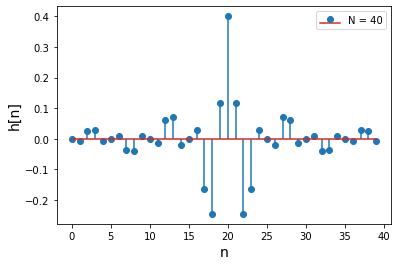

In [7]:
# show the impulse response for our example bandpass filter
h = impulse(low, high, N=40)
fig, ax = plt.subplots()
plot_impulse(h, ax)
plt.show()

<b>What does truncating the impulse response $h_d[n] \rightarrow h[n]$ do to the ideal amplitude response $A_d(\theta) \rightarrow \ ?$

The frequency response of the filter is the Fourier transform of the truncated impulse response $h[n]$.
<br>
<br>
<p style="text-align: center;">
    $
    H^f(\theta) = \sum \limits_{n=0}^{2M}h[n]e^{-i \theta n} \quad (8)
    $ 
</p>

Since Type I FIR filters are symmetric $h[n] = h[N-n]$ where N=2M is the length of the filter. Using this symmetry we can write:

<p style="text-align: center;">
    $
    \begin{align*}
    H^f(\theta) &= \sum \limits_{n=0}^{2M}h[n]e^{-i \theta n} =  \sum \limits_{n=0}^{2M} h[n]e^{-i \theta M}e^{i \theta (M-n)} \\
    &= e^{-i \theta M} \left\{\sum \limits_{n=0}^{2M} h[n] \ e^{i \theta (M-n)} \right\} \\
    &= e^{-i \theta M} \left\{h[M] + \sum \limits_{n=0}^{M-1} h[n] \ e^{i \theta (M-n)} + \sum \limits_{n=M+1}^{2M} h[n] \ e^{i \theta (M-n)}\right\}\\
    & \ letting \ n' =  N-n \ and \ rename \ n' = n\\
    &= e^{-i \theta M} \left\{h[M] + \sum \limits_{n=0}^{M-1} h[n] \ e^{i \theta (M-n)} + \sum \limits_{n=0}^{M-1} h[N-n] \ e^{i \theta (M-n)}\right\}\\
    &= e^{-i \theta M} \left\{h[M] + 2 \sum \limits_{n=0}^{M-1} h[n]cos[\theta (M-n)] \right\} \quad (8)
    \end{align*}
    $
<p style="text-align: center;">


So the amplitude response after truncation is:

<p style="text-align: center;">
    $
    \begin{align*}
    A(\theta) = \left\{h[M] + 2 \sum \limits_{n=0}^{M-1} h[n]cos[\theta (M-n)] \right\} \quad (9)
    \end{align*}
    $
</p>

Lets write a function for the truncated amplitude response.

In [8]:
def amplitude_response(h, nthetas=1000):
    """Returns the amplitude response of a truncated Type I FIR filter (Eq. 9).
    
    Args:
        h: 1-D array
            An array of truncated filter coeffecients.
        nthetas: int
            The number of frequencies in rads/sec to evaluate the amplitude response at.
            
    Returns:
        A 1-D array of size nthetas from 0 to 1 and a 1-D array of size nthetas of amplitude responses.
    """
    
    M = len(h) // 2
    thetas = np.linspace(0, np.pi, nthetas)
    
    # initialize the results at each theta with h[M]
    result = h[M] * np.ones(nthetas)
    
    # add the sum contribution to each theta in result
    for idx, theta in enumerate(thetas):
        
        result[idx] += np.sum([2 * h[M-n] * np.cos(theta * n) for n in range(1, M+1)])
    
    return thetas, result
    

In [9]:
# lets also make a function that will plot the amplitude response to a generic mpl axis
def plot_amplitude_response(thetas, response, ax, **kwargs):
    """Plots the truncated amplitude response to a matplotlib axis."""
    
    ax.plot(thetas, response, **kwargs)
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.set_xlabel(r'$\theta$', fontsize=14)
    ax.set_ylabel(r'$A(\theta)$', fontsize=14)
    ax.legend()

Ok so lets pause and review what we have. We have the ideal amplitude response $A_d(\theta)$ that we want to approximate, we have a truncated impulse response $h[n]$ and we have the truncated amplitude response $A(\theta)$. So lets compare how well the truncated amplitude response matches our desired ideal response for a range of filter orders.

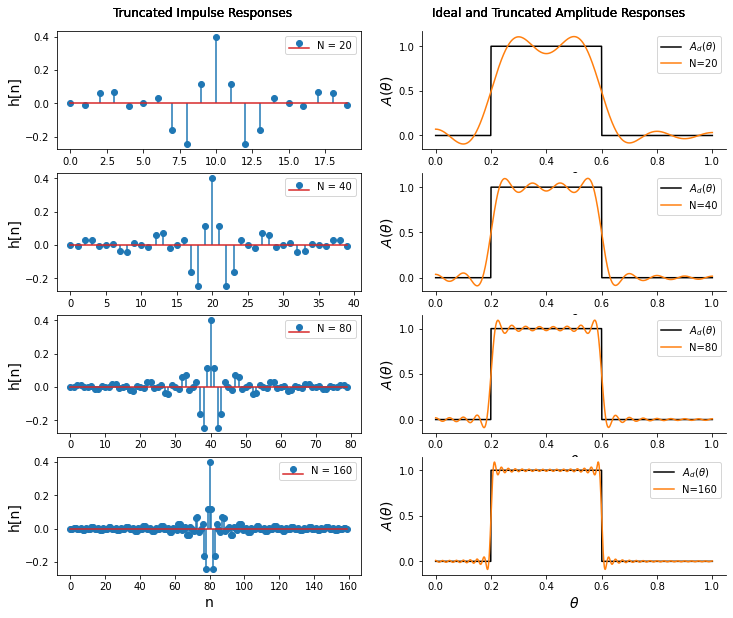

In [10]:
low, high = 0.2 * np.pi, 0.6 * np.pi
orders = [20, 40, 80, 160]
npts = 1000

fig, axarr = plt.subplots(len(orders), 2, figsize=(12,10))
for N, row in zip(orders, axarr):
    
    # compute truncated impulse responses
    h = impulse(low, high, N)
    
    # compute the ideal amplitude response
    thetas, A_d = ideal_amplitude_response(low, high, npts)
    
    # compute the amplitude response after truncation of the filter
    _, A = amplitude_response(h, npts)
    
    # plot the impulse, the ideal amplitude response and the truncated amplitude response
    plot_impulse(h, row[0])
    plot_ideal_response(thetas, A_d, row[1], color='k', label=r'$A_d(\theta)$')
    plot_amplitude_response(thetas, A, row[1], color='tab:orange', label='N={}'.format(N))
    
    plt.figtext(.19, .9, 'Truncated Impulse Responses', fontsize=12)
    plt.figtext(.56, .9, 'Ideal and Truncated Amplitude Responses', fontsize=12)
plt.show()

The method we just used to create these filters is called the <b><font color='firebrick'>Impulse Response Truncation</b></font> method. Notice that as the filter order increases the <font color='darkorange'>amplitude response</font> has a narrower <b>transition width</b>. It moves from the passband to the stop band more steeply. Second, notice that the <b>gains in the pass and stop bands</b> are oscillatory and their max amplitudes and are not affected by the filter's order. These three parameters, the <b>transition width</b>, the max <b>pass band gain</b>, $g_{pass}$, and the max <b>stop band gain</b>, $g_{stop}$, are the the big three design criteria that we will use to design filters.
<br>
<br>
<b><i><font size=3>Why are there ripples in the pass and stop bands? Also, why can't we remove them by increasing the filter's order, N?</b></i></font>

The problem with the impulse response trunctation design method is that truncating the filter is equivalent to applying a rectangular window $w_r[n]$ to the filters coeffecients. 
</br>
</br>
<p style="text-align: center;">
    $
    \begin{align*}
        h[n] = \begin{cases}
                    w_r[n]h_d[n] & 0 \leq n \leq N \\
                    0 & otherwise
                \end{cases} \quad (9)
    \end{align*}        
    $
</p>
</br>
<center> where </center>
</br>
<p style="text-align: center;">
    $
    \begin{align*}
        w_r = \begin{cases}
                  1 & 1 \leq n \leq N \\
                  0 & otherwise
                \end{cases} \quad (10)
    \end{align*}            
    $
</p>

The Fourier transform of this rectangular window is:
<p style="text-align: center;">
    $
    \begin{align*}
        W_{r}^{f} &= \sum \limits_{n=0}^{N-1} e^{-i \theta n} \\
        \\
        &= \frac{1-e^{-i \theta n}}{1-e^{-i \theta}} \\
        \\
        &= \frac{sin(\theta N/2)}{sin(\theta/2)}e^{-i \theta (N-1)/2} \quad (11)
    \end{align*}
    $
</p>
The function 
<p style="text-align: center;">
    $D(\theta, N) = \frac{sin(\theta N/2)}{sin(\theta/2)} \quad (12)$
</p>
<br>
is called the Dirichlet kernel. Note from moving from line 1 to 2 in Eq. 11 we used the definition of a geometric series and in moving from 2 to 3 we used the trigonometric identity (see https://en.wikipedia.org/wiki/Dirichlet_kernel)

So when we truncated the impulse response $h_d[n]$ we were performing the following convolution in the frequency domain:
<br>
<br>
<p style="text-align: center;">
    $
    \frac{1}{2 \pi} ( W_r^f * H_d^f(\theta)) = \frac{1}{2 \pi} ( D(\theta, N) \ e^{-i \theta (N-1)/2} * \ H_d^f(\theta)) \quad (13)
    $
</p>

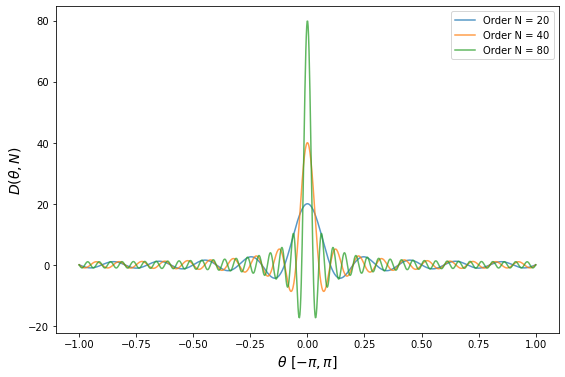

In [11]:
# Lets plot the Dirichlet kernel for a few orders
orders = [20, 40, 80]
thetas = np.linspace(-1, 1, 1000)

fig, ax = plt.subplots(figsize=(9, 6))
for order in orders:
    D = np.sin(thetas * order/2*np.pi)/np.sin(thetas/2*np.pi)
    ax.plot(thetas, D, label='Order N = {}'.format(order), alpha=0.75)
    ax.set_xlabel(r'$\theta \ [-\pi, \pi]$', fontsize=14)
    ax.set_ylabel(r'$D(\theta, N)$', fontsize=14)
    ax.legend()
plt.show()

Notice that when the order is low the main lobe is wide, this corresponds to the wider transition widths we observed in the truncated amplitude responses (see orange curves approximating $A_d(\theta)$ in previous fig). Also notice that the 1st side lobes are similar in height independent of the order. These lobes correspond to the ripples we see in the pass and stop bands of the previous figure. <b>So the reason we see large ripples in the pass and stop bands are due to the large side lobes of the Dirichlet Kernel-- the Fourier transform of the rectangular window $w_r$ used to truncate $h_d[n] \rightarrow h[n]$.</b> 

<center>
 <b><font size=3> Is there a better window $w[n]$ we can use to truncate $h_d[n]$ in Eq. 9 to give us smaller ripples? </font></b>
</center>

<b>Yes!</b> Since the 1950s many windows have been developed. The shape of each window is different and this impacts the big three criteria; <b>transition width, pass band gain $g_{pass}$, and stop band gain $g_{stop}$</b>. Scipy allows us to build the coeffecients $h[n]$ using a variety of these developed windows. Openseize wraps Scipy's design capabilities so that the filter's coeffecients, impulse response and phase response can be easily viewed. In the next section we will show how to build these windowed FIR filters and explain the design specifications using a low-pass filter. 

## FIR Filter Design in Openseize

Filters in Opensieze are classes that can make specific filters to apply to data. Lets start by looking at what FIR filters are available.

In [12]:
# inspect the fir.py module of openseize list all fir filters available
inspect.getmembers(fir, inspect.isclass)

[('Bartlett', openseize.filtering.fir.Bartlett),
 ('Blackman', openseize.filtering.fir.Blackman),
 ('FIR', openseize.filtering.bases.FIR),
 ('Hamming', openseize.filtering.fir.Hamming),
 ('Hanning', openseize.filtering.fir.Hanning),
 ('Kaiser', openseize.filtering.fir.Kaiser),
 ('Rectangular', openseize.filtering.fir.Rectangular),
 ('Remez', openseize.filtering.fir.Remez)]

This module contains 3 ways to design FIR filters. The first is called the <b> general cosine windowed design</b>. These include:
- Bartlett
- Blackman 
- Hamming 
- Hanning
- Rectangular

These filters allow for control of the transition width **but** not the amount of pass and stop band gain $g_{pass}$ and $g_{stop}$. These parameters are controlled by the windows shape. Lets design a Hamming window low pass filter that has a cutoff frequency of 600Hz.

### General Cosine Window Design

In [13]:
# lets ask for help to see how to create the Hamming filter
# you can also just type help(fir.Hamming) to get the docs for all methods
print(fir.Hamming.__doc__)
help(fir.Hamming.__init__)

A callable type I FIR using a Hamming window.

    Attrs:
        fpass, fstop: float or length 2 sequence
            Pass and stop band edge frequencies (Hz).
            For example:
                - Lowpass: fpass = 1000, fstop = 1100
                - Highpass: fpass = 2000, fstop = 1800 
                - Bandpass: fpass = [400, 800], fstop = [300, 900]
                - Bandstop: fpass = [100, 200], fstop = [120, 180]
        fs: int
            The sampling rate of the data to be filtered.

    Characteristics:
        main lobe width (MLW) = 8 pi / len(taps) 
        side lobe height (SLH) = -43.8 dB
        side lobe roll-off rate (SLRR) = -6 dB/octave
        approximate peak error (APE) = -53 dB
        
    The Hamming window is a good general purpose window with strong
    attenuation in the pass and stop bands.
    
Help on function __init__ in module openseize.filtering.fir:

__init__(self, fpass, fstop, fs)
    Initialize this Rectangular Windowed FIR.



This documentation tells us that to intialize this filter we need a fpass, fstop, and sampling frequency fs in Hertz. It also tells us the characterization of the window. It has a main lobe width $MLW = 8 \pi / (num. taps)$ The number of taps will be determined for us by |fpass - fstop|.

In [14]:
# make a lowpass hamming filter with edge freqs at 500 and 700 (meaning the cutoff is 600 Hz)
hamming = fir.Hamming(fpass=500, fstop=700, fs=5000)

#lets print the hamming filter to see what it looks like
print(hamming)

Hamming Object
---Attributes & Properties---
{'fpass': array([500]),
 'fstop': array([700]),
 'gpass': 0.01946708356540905,
 'gstop': -53,
 'fs': 5000,
 'nyq': 2500.0,
 'width': 200,
 'coeffs': array([-7.49371213e-19, -3.60231815e-04, -5.54158004e-04, -4.60552316e-04,
       -8.20168958e-05,  4.26750744e-04,  7.99026907e-04,  7.74598307e-04,
        2.58341279e-04, -5.67742661e-04, -1.27191548e-03, -1.37207991e-03,
       -6.31916515e-04,  7.13788513e-04,  1.97681805e-03,  2.33492724e-03,
        1.32546499e-03, -7.64703441e-04, -2.89389774e-03, -3.74317930e-03,
       -2.48430035e-03,  5.86215770e-04,  3.97993419e-03,  5.68228035e-03,
        4.28878919e-03, -5.05825569e-18, -5.17130873e-03, -8.26510879e-03,
       -6.98959848e-03, -1.24472498e-03,  6.38928277e-03,  1.16875270e-02,
        1.10006379e-02,  3.55078911e-03, -7.54706067e-03, -1.63753035e-02,
       -1.71624610e-02, -7.71520450e-03,  8.55791716e-03,  2.34480716e-02,
        2.76475387e-02,  1.58379257e-02, -9.34353685e-03

This tells us that the filter has a maximum pass band gain of 0.019 dB and a minimum stop band attenuation of -53 dB. If your not familiar with the dB scale, now is a good time to review it because it is the standard way to represent pass and stop band attenuations in signal processing. It is defined as: $X (dB) = -20 * log_{10}(V_{out} / V_{in})$. So a 40 dB attenuation equates to $V_{out}/V_{in} = 10^{-40/20} = 99\%$ attenuation. The printout also tells us there are 101 coeffecients in this filter.
<br>
<br>
All the filters in Opensieze have two methods that you will need routinely. The <b><font color='firebrick'> plot</b></font> method allows you to plot the impulse response, the frequency response and the amplitude response functions we discussed in the "Mathematics" section. The <b><font color='firebrick'>__call__</b></font> method, which we will examine later, allows you to apply the filter to producers or an ndarray. This triggers openseize to use its iterative methods to apply the filter to data that may not fit into your RAM memory. For now we will look at the plot method to help us design our low pass filter.

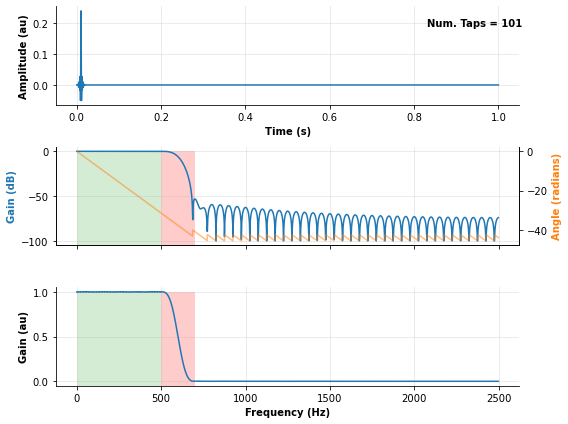

In [15]:
hamming.plot()

Okay so we have the impulse resonse on top, the frequency response and phase response in the middle and the amplitude gain on the bottom. Lets zoom in on the top and middle panels to show in greater detail the filters responses.

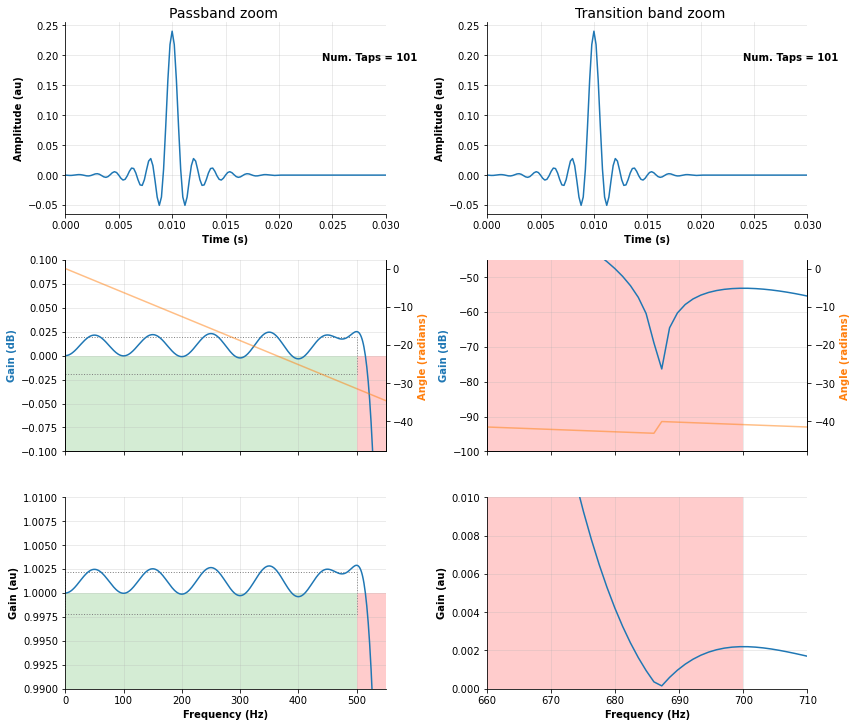

In [16]:
fig, axarr = plt.subplots(3, 2, figsize=(12,10))
left_col, right_col = axarr[:,0], axarr[:,1]

# zoom in on passband ripple
left_col = hamming.plot(axarr=left_col, show=False)
left_col[0].set_xlim([0, 0.03])
left_col[1].set_xlim([0, 550])
left_col[1].set_ylim([-0.1, 0.1])
left_col[2].set_xlim([0, 550])
left_col[2].set_ylim([.99, 1.01])

# zoom in on stop band edge frequency
right_col = hamming.plot(axarr=right_col, show=False)
right_col[0].set_xlim([0, 0.03])
right_col[1].set_xlim([660, 710])
right_col[1].set_ylim([-100, -45])
right_col[2].set_ylim([0, 0.01])

plt.figtext(.2, .99, 'Passband zoom', fontsize=14)
plt.figtext(.67, .99, 'Transition band zoom', fontsize=14)

plt.show()

<b>Left Column:</b> We see that the impulse response peaks at 0.01 secs. This corresponds to a delay of M/fs = 50/5000 where M is half the filter order N=100 (remember taps=N+1). Second in the middle plot we see that the amplitude response in the pass band slightly exceeds the expected pass gain of 0.019 dB. Because we are still performing a truncation and the general cosine windows do not allow us to specify the pass or stop band gains, there will be small errors in the pass band specification. The gain percent from the bottom plot shows the max error is well below 0.05%.
<br>
<br>
<b>Right Column:</b> In the transition between the pass and stop band we see that the filters attenuation reaches -53 dB by the end of the transition band. This corresponds to an attenuation of 1 - 0.022 = 99.8%
<br>
<br>
Also notice that on the zoomed out plot (previous figure) the phase of the filter in the passband (green area) is linear. This is why the delay of the filter is constant. This means when we apply the filter to data, the filtered response will be shifted in time by 0.01 secs. This is easy to fix by simply shifting it back. This property is one of the nice features of FIRs.

### Parameterized Window Design

In [17]:
# reinspect the fir.py module of openseize list all fir filters available
inspect.getmembers(fir, inspect.isclass)

[('Bartlett', openseize.filtering.fir.Bartlett),
 ('Blackman', openseize.filtering.fir.Blackman),
 ('FIR', openseize.filtering.bases.FIR),
 ('Hamming', openseize.filtering.fir.Hamming),
 ('Hanning', openseize.filtering.fir.Hanning),
 ('Kaiser', openseize.filtering.fir.Kaiser),
 ('Rectangular', openseize.filtering.fir.Rectangular),
 ('Remez', openseize.filtering.fir.Remez)]

The second type of FIR design in Openseize's FIR module is the <b>parameterized Kaiser window</b>. The general cosine windows do not allow us to control the gain in the pass and stop bands. These were determined by the shape of the window. The Kaiser window has a parameter $\beta$ that allows the window shape to change. It exchanges increasing the width of the main lobe for lower side lobe amplitude. Thus, it allows us to sacrifice transition width for lower gain in the pass and stop bands. Importantly, it does not allow us to vary the gains independently. The kaiser window has only a single parameter to vary so it picks the stricter of $g_{pass}$ and $g_{stop}$. Lets build a Kaiser window filter to understand this.  

In [18]:
# lets see how to make one by asking for help
# you can also just type help(fir.Kaiser) to get the docs for all methods
print(fir.Kaiser.__doc__)
help(fir.Kaiser.__init__)

A callable Type I FIR Filter using a Kaiser window. 

    Designs a Kaiser windowed filter that meets the stricter of the pass and
    stop band attenuation criteria.

    Attrs:
        fpass, fstop: float or length 2 sequence
            Pass and stop band edge frequencies (Hz).
            For example:
                - Lowpass: fpass = 1000, fstop = 1100
                - Highpass: fpass = 2000, fstop = 1800 
                - Bandpass: fpass = [400, 800], fstop = [300, 900]
                - Bandstop: fpass = [100, 200], fstop = [120, 180]
        fs: int
            The sampling rate of the data to be filtered.
        gpass: float
            The maximum loss in the pass band (dB). Default is 1.0 dB which
            is an amplitude loss of ~ 11%.
        gstop: float
            The minimum attenuation in the stop band (dB). The default is 40
            dB which is an amplitude loss of 99%

    References:
        1. Ifeachor E.C. and Jervis, B.W. (2002). Digital Signal Proces

So to create this filter we now specify the max loss/gain in the pass band in dB and the required minimum attenuation in the stop band. Kaiser windows can not change these independently. Instead, they choose the stricter of the gpass and gstop criteria to meet.

In [19]:
# use the default gpass = 1 dB loss and gstop=40 dB stop band attenuation
# Technical point -  the gain in the pass band is not the attenuation; a 1 dB gain is 19 dB attenuation. 
# For more details see filtering.bases.FIR.pass_attenuation. In this example the kaiser window will choose
# the 40 dB criteria since gstop=40 > 19 dB (stricter of the 2 attenuations).
kaiser = fir.Kaiser(fpass=500, fstop=700, fs=5000, gpass=1, gstop=40)
print(kaiser)

Kaiser Object
---Attributes & Properties---
{'fpass': array([500]),
 'fstop': array([700]),
 'gpass': 1,
 'gstop': 40,
 'fs': 5000,
 'nyq': 2500.0,
 'width': 200,
 'coeffs': array([ 1.29257201e-03,  2.10543509e-03,  1.77862126e-03, -2.31334819e-18,
       -2.57744217e-03, -4.44604112e-03, -4.02525083e-03, -7.62141100e-04,
        4.13475313e-03,  7.95230654e-03,  7.83354402e-03,  2.63537802e-03,
       -5.81639987e-03, -1.30601535e-02, -1.41209790e-02, -6.52985170e-03,
        7.43059687e-03,  2.08335566e-02,  2.50769813e-02,  1.46316436e-02,
       -8.77282564e-03, -3.50035409e-02, -4.86654391e-02, -3.56580241e-02,
        9.66180682e-03,  8.02130045e-02,  1.57267530e-01,  2.16915270e-01,
        2.39350179e-01,  2.16915270e-01,  1.57267530e-01,  8.02130045e-02,
        9.66180682e-03, -3.56580241e-02, -4.86654391e-02, -3.50035409e-02,
       -8.77282564e-03,  1.46316436e-02,  2.50769813e-02,  2.08335566e-02,
        7.43059687e-03, -6.52985170e-03, -1.41209790e-02, -1.30601535e-02,
 

So notice here that by allowing gstop to be 40 dB instead of the fixed 53 dB of the hamming window we were able to reduce the number of filter coeffs to 57. Lets now plot this filter.

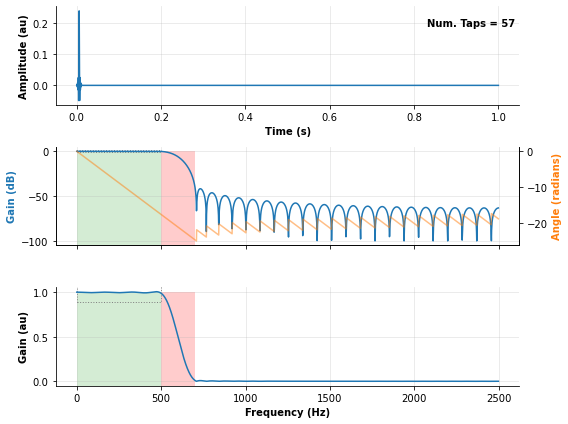

In [20]:
kaiser.plot()

Again we will zoom in on the impulse and the frequency response in the pass band

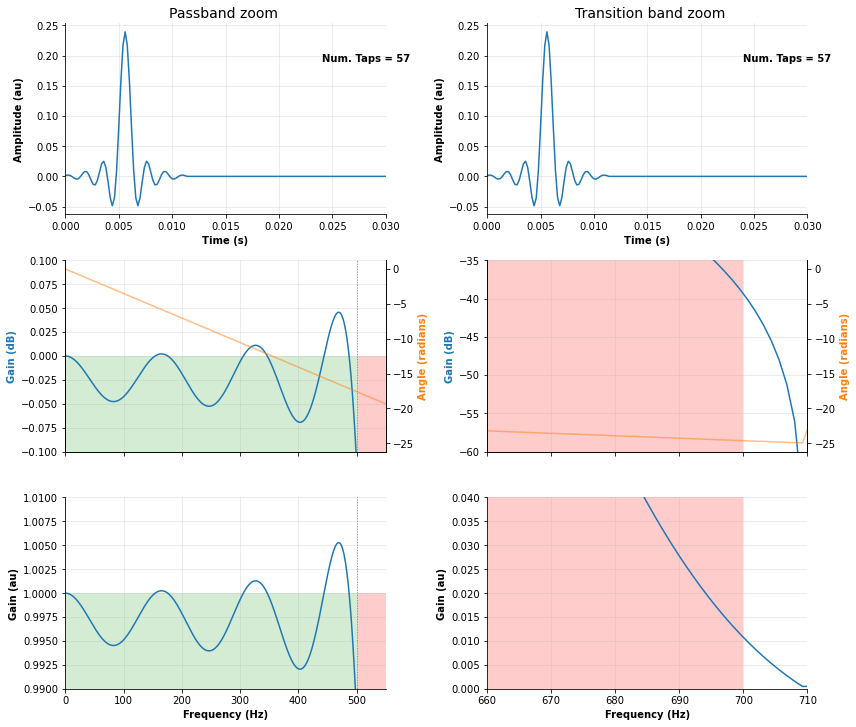

In [21]:
fig, axarr = plt.subplots(3, 2, figsize=(12,10))
left_col, right_col = axarr[:,0], axarr[:,1]

# zoom in on passband ripple
left_col = kaiser.plot(axarr=left_col, show=False)
left_col[0].set_xlim([0, 0.03])
left_col[1].set_xlim([0, 550])
left_col[1].set_ylim([-0.1, 0.1])
left_col[2].set_xlim([0, 550])
left_col[2].set_ylim([.99, 1.01])

# zoom in on stop band edge frequency
right_col = kaiser.plot(axarr=right_col, show=False)
right_col[0].set_xlim([0, 0.03])
right_col[1].set_xlim([660, 710])
right_col[1].set_ylim([-60, -35])
right_col[2].set_ylim([0, 0.04])

plt.figtext(.2, .99, 'Passband zoom', fontsize=14)
plt.figtext(.67, .99, 'Transition band zoom', fontsize=14)

plt.show()

<b>Left Column:</b> Notice the lower filter (compared to our Hamming window filter) in the top panel means that the filter will shift the response by only 28 samples ~ 0.0056 seconds. In the second, row, we also see that the last peak in the frequency response is ~0.05 dB far below the 1 dB we specified. That's because the Kaiser window with it single parameter chose the stricter of the pass and stop attenuations. In this example that was the 40 dB requirement in the stop band. 
<br>
<br>
<b>Right Column:</b> At the edge frequency of 700 Hz our frequency response (middle panel) is very near the -40 dB specification we provided and thus the amplitude attenuation at this frequency is ~ 99%.
<br>
<br>
It is also important to notice that with the Hamminng window, it's shape forces it to reach -53 dB by the end of the transition band. The Kaiser window allowed us to set this to -40 dB and thus save almost half the computations when we apply the filter to data (101 taps versus 57 for the Kaiser). We will look at one last design method offered in Openseize and then explore how these filters can be applied to data.

### Parks-McClellan Window Design

The Kaiser window method gave us control over the stricter of the pass and stop band attenuations, but did not allow us to adjust these attenuations independently. In fact, this leads to filters whoise orders are higher than they need to be. The <b>Parks-McClellan window design method<b> designs an <b>optimal filter</b> by minimizing the weighted largest deviation $E(\theta)$ of the filters actual response, $A(\theta)$ from the desired response $D(\theta)$ response:

<p style="text-align: center;">
    $
     \min E(\theta) = \underset{A(\theta)} \min \ \left\{\Omega(\theta) \ \mid A(\theta)-D(\theta) \mid \right\} \quad (14)
    $
</p>

Here the weights $\Omega(\theta)$ is an array of weights over the desired responses at each theta $D(\theta)$. These weights can be used to adjust the attenuation in each of the bands independently. This method is also suitable for building multi-band filters. The algorithm that carries out this minimization is called the Remez-exchange algorithm. <b><font color='firebrick'> Before testing, a word of Caution</b></font>. The Remez algorithm can give filters that do not meet the specifications that are provided or worse the algorithm may fail to converge altogether. It is imperative to check the plots of Remez filters before applying them to data.

In [22]:
# lets see how to make one by asking for help
# you can also just type help(fir.Kaiser) to get the docs for all methods
print(fir.Remez.__doc__)
help(fir.Remez.__init__)

The Parks-McClellan optimal filter obtained with the Remez 
    exchange algorithm.
    
    This FIR is designed by minimizing: E(f) = W(f) |A(f) - D(f)|
    where E(f) is a the weighted difference of the actual frequency 
    response A(F) from the desired frequency response D(f) for f in 
    [0, nyquist] (see scipy.signal.remez). As an optimal design method it
    can result in a FIR with a lower number of taps than the Kaiser method.
    To construct this filter a sequence of bands and the desired gains D(f) 
    for each band must supplied. This parameterization allows for the
    specification of mixed bands (e.g. lowpass with a bandstop) in contrast 
    to other FIRS such as Kaiser.

    Attrs:
        bands: 1-D array like
            A monotonically increasing sequence of pass & stop band edge
            frequencies than includes the 0 and nyquist frequencies.
        desired: 1-D array like
            A sequence containing the desired gains (1 or 0) in each band.
        

In [23]:
# Since remez supports multiple bands the bands are specified as an array
# to match the kaiser pass band gain set gpass to ~ 0.05
remez = fir.Remez(bands=[0, 500, 700, 2500], desired=[1, 0], gpass=.05, gstop=40, fs=5000)

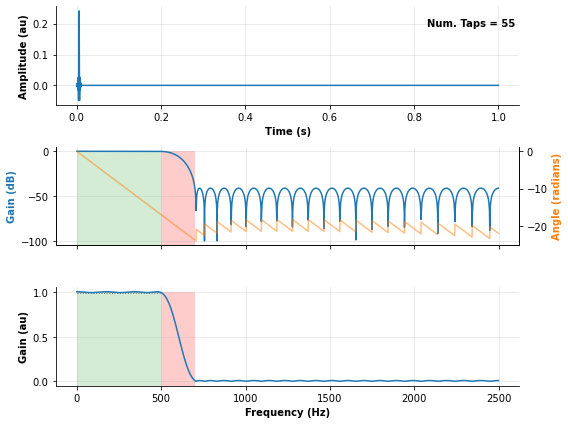

In [24]:
remez.plot()

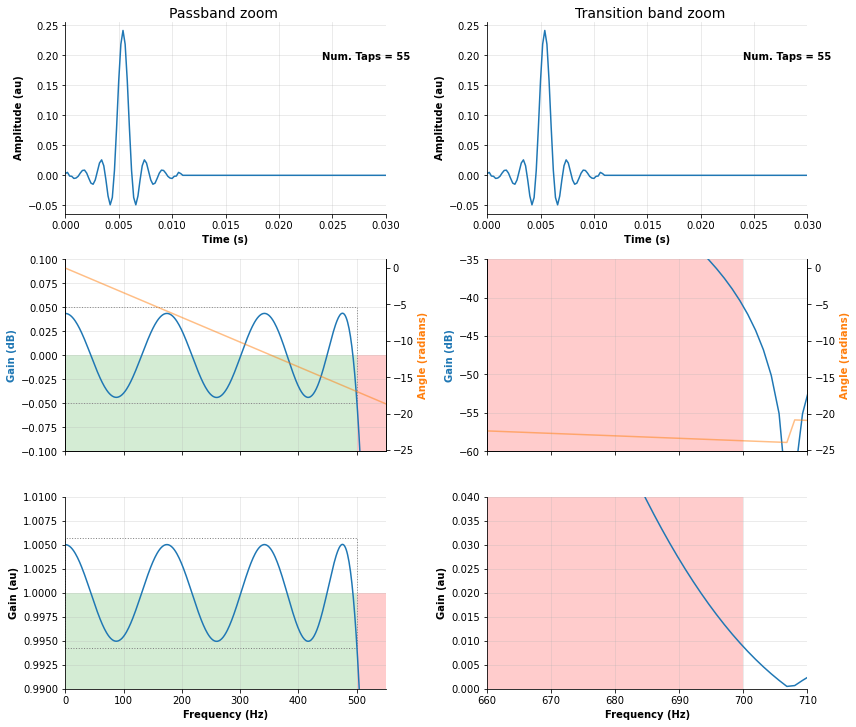

In [25]:
# Lets again zoom in to see the filters details better
fig, axarr = plt.subplots(3, 2, figsize=(12,10))
left_col, right_col = axarr[:,0], axarr[:,1]

# zoom in on passband ripple
left_col = remez.plot(axarr=left_col, show=False)
left_col[0].set_xlim([0, 0.03])
left_col[1].set_xlim([0, 550])
left_col[1].set_ylim([-0.1, 0.1])
left_col[2].set_xlim([0, 550])
left_col[2].set_ylim([.99, 1.01])

# zoom in on stop band edge frequency
right_col = remez.plot(axarr=right_col, show=False)
right_col[0].set_xlim([0, 0.03])
right_col[1].set_xlim([660, 710])
right_col[1].set_ylim([-60, -35])
right_col[2].set_ylim([0, 0.04])

plt.figtext(.2, .99, 'Passband zoom', fontsize=14)
plt.figtext(.67, .99, 'Transition band zoom', fontsize=14)

plt.show()

So we see that the Remez filter with a gpass equal to that of the Kaiser performs slightly better in the sense that it has 2 less taps. But we can do better. Let's increase the gpass but add a weight factor to reduce it again. Adding weight factors does not increase the tap number but does decrease the gain in the pass band.

In [26]:
# relax the gpass to reduce the tap number but weight the objective function Eq.14
remez2 = fir.Remez(bands=[0, 500, 700, 2500], desired=[1, 0], gpass=.2, gstop=40, fs=5000, weight=[100, 30])

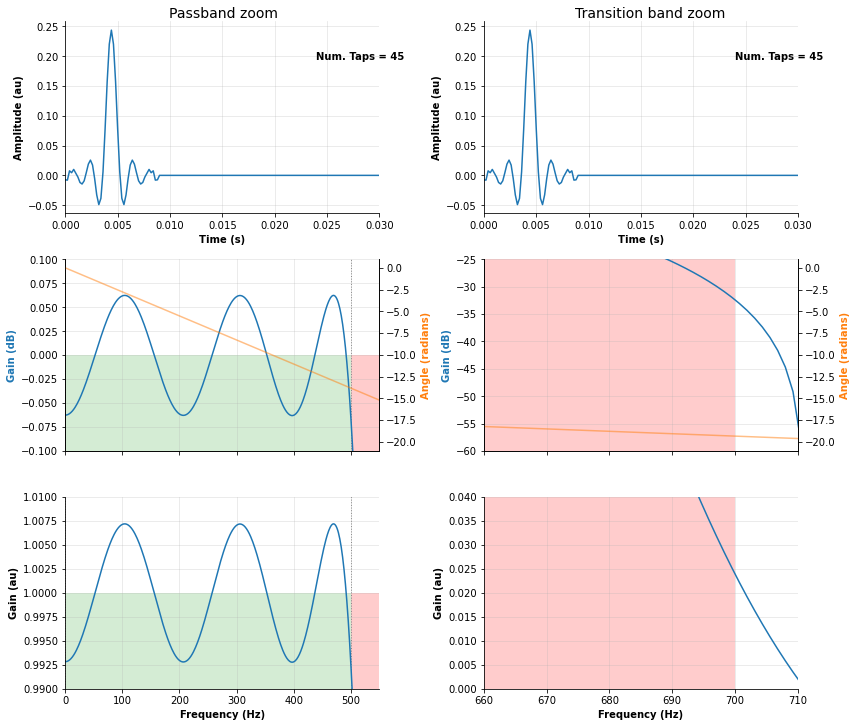

In [27]:
fig, axarr = plt.subplots(3, 2, figsize=(12,10))
left_col, right_col = axarr[:,0], axarr[:,1]

# zoom in on passband ripple
left_col = remez2.plot(axarr=left_col, show=False)
left_col[0].set_xlim([0, 0.03])
left_col[1].set_xlim([0, 550])
left_col[1].set_ylim([-0.1, 0.1])
left_col[2].set_xlim([0, 550])
left_col[2].set_ylim([.99, 1.01])

# zoom in on stop band edge frequency
right_col = remez2.plot(axarr=right_col, show=False)
right_col[0].set_xlim([0, 0.03])
right_col[1].set_xlim([660, 710])
right_col[1].set_ylim([-60, -25])
right_col[2].set_ylim([0, 0.04])

plt.figtext(.2, .99, 'Passband zoom', fontsize=14)
plt.figtext(.67, .99, 'Transition band zoom', fontsize=14)

plt.show()

Notice, with a good weighting we can achieve similar results to the Kaiser and the unweighted Remez but with 10-12 less taps. That translates into ~ 20-25% fewer multiplications to apply the filter! Finally, Remez supports the construction of multiband filters as the example below demonstrates.

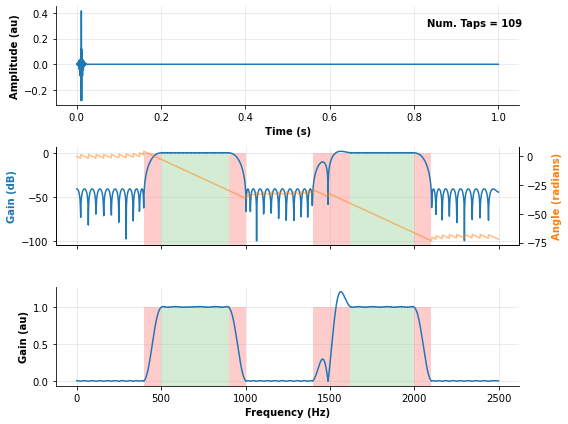

In [28]:
remez3 = fir.Remez(bands=[0, 400, 500, 900, 1000, 1400, 1620, 2000, 2100, 2500], 
                   desired=[0, 1, 0, 1, 0], gpass=.05, gstop=40, fs=5000)
remez3.plot()

Notice that as the asymmetry in the two transition bands for the right pass band leads to an a gain increase in the transition band. Depending on your data, this may be problematic. It is a good warning about Remez filters. They should be carefully checked to make sure that meet the design criteria.

## Applying FIR Filters to Large Datasets

All filters in Openseize have a __call__ method. This is where Openseize begins to flex its muscle. Unlike other scientific packages and scripting languages, Openseize can take the filters we designed above and apply them to producer objects. If you have read the producer tutorial, you will have seen how Openseize can produce data from files, from in-memory arrays or even generating functions on-the-fly. Filters in Openseize can read the data from these producers and return a new producer that produces filtered values. All of this happens without ever loading the data into memory all at once. Lets explore this functionality.

Lets take a look at the kaiser's call method. We'll start by building a fresh kaiser filter object that will low pass all data below 200 Hz.

In [29]:
# in a few cells we are going to read data that is 5 kHz so set fs=5000.
# this will make a 57 tap filter
kaiser = fir.Kaiser(fpass=200, fstop=400, gpass=0.5, gstop=40, fs=5000)

#lets print the call method of this filter
help(kaiser.__call__)

Help on method __call__ in module openseize.filtering.bases:

__call__(data, chunksize, axis, mode='same', **kwargs) method of openseize.filtering.fir.Kaiser instance
    Apply this filter to an ndarray or producer of ndarrays.
    
    Args:
        data: ndarray or producer of ndarrays
            The data to be filtered.
        chunksize: int
            The number of samples to hold in memory during filtering.
        axis: int
            The axis of data along which to apply the filter. If data is
            multidimensional, the filter will be independently applied
            along all slices along axis.
        mode: str
            A numpy convolve mode; one of 'full', 'same', 'valid'.
                Full:
                    This mode includes all points of the convolution of
                    the filter window and data. This mode does not 
                    compensate for the delay introduced by the filter.
                Same:
                    This mode (Default

We are going to need some data to work with so lets get Openseize's edf demo data called "recording_001.edf".

In [30]:
datapath = demos.paths.locate('recording_001.edf')

#build a reader instance -- if you don't recall what this is, please see the file_reading demo.
reader = Reader(datapath)
print(reader)

Reader Object
---Attributes & Properties---
{'path': PosixPath('/home/matt/python/nri/openseize/demos/data/recording_001.edf'),
 'header': {'version': '0',
            'patient': 'PIN-42 M 11-MAR-1952 Animal',
            'recording': 'Startdate 15-AUG-2020 X X X',
            'start_date': '15.08.20',
            'start_time': '09.59.15',
            'header_bytes': 1536,
            'reserved_0': 'EDF+C',
            'num_records': 3775,
            'record_duration': 1.0,
            'num_signals': 5,
            'names': ['EEG EEG_1_SA-B', 'EEG EEG_2_SA-B', 'EEG EEG_3_SA-B',
                      'EEG EEG_4_SA-B', 'EDF Annotations'],
            'transducers': ['8401 HS:15279', '8401 HS:15279', '8401 HS:15279',
                            '8401 HS:15279', ''],
            'physical_dim': ['uV', 'uV', 'uV', 'uV', ''],
            'physical_min': [-8144.31, -8144.31, -8144.31, -8144.31, -1.0],
            'physical_max': [8144.319, 8144.319, 8144.319, 8144.319, 1.0],
            'dig

So we have 4 channels of data each containing 18875000 samples sampled at 5 kHz. Next, lets build a producer to give to our kaiser filter.


In [31]:
# now build a producer of data from this reader instance
pro = producer(reader, chunksize=1e6, axis=-1)
print(pro)

ReaderProducer Object
---Attributes & Properties---
{'data': Reader(path),
 'axis': -1,
 'kwargs': {},
 'chunksize': 1000000,
 'shape': (4, 18875000)}

Type help(ReaderProducer) for full documentation


Okay we are all set, we have a producer of data from a file, we have a filter to apply. We are going to 

In [32]:
t0 = time.perf_counter()
kpro = kaiser(pro, chunksize=10e6, axis=-1)
oresult = kpro.to_array()
print(time.perf_counter() - t0)

KeyboardInterrupt: 

In [ ]:
t0 = time.perf_counter()
arr = reader.read(0)
h=kaiser.coeffs.reshape(1,-1)
sp_result = sp.signal.oaconvolve(h, arr, axes=-1)
print(time.perf_counter() - t0)

#FIXME THERE IS SOME PROBLEM IN OPENSEIZE OACONVOLVE. IT IS TAKING TOO LONG